In [1]:
#在本节中，我们将根据 8.4节 中的描述，从头开始基于循环神经网络实现字符级语言模型。
#这样的模型将在 H. G. Wells 的时光机器数据集上训练。和前面 8.3节 中介绍过的一样，我们先读取数据集。
!pip install d2l
%matplotlib inline
import math
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

     |████████████████████████████████| 83 kB 2.0 MB/s 


In [2]:
#8.5.1. 独热编码
F.one_hot(torch.tensor([0, 2]), len(vocab))

tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0]])

In [3]:
#我们经常转换输入的维度，以便获得形状为（时间步数, 批量大小, 词汇表大小）的输出。
#这将使我们能够更方便地通过最外层的维度，一步一步地更新小批量数据的隐藏状态。
X = torch.arange(10).reshape((2, 5))
F.one_hot(X.T, 28).shape

torch.Size([5, 2, 28])

In [4]:
#8.5.2. 初始化模型参数
#接下来，我们初始化循环神经网络模型的模型参数。
#隐藏单元数num_hiddens是一个可调的超参数。当训练语言模型时，输入和输出来自相同的词汇表。因此，它们具有相同的维度，即词汇表的大小。
def get_params(vocab_size, num_hiddens, device):
    num_inputs = num_outputs = vocab_size

    def normal(shape):
        return torch.randn(size=shape, device=device) * 0.01

    # 隐藏层参数
    W_xh = normal((num_inputs, num_hiddens))
    W_hh = normal((num_hiddens, num_hiddens))
    b_h = torch.zeros(num_hiddens, device=device)
    # 输出层参数
    W_hq = normal((num_hiddens, num_outputs))
    b_q = torch.zeros(num_outputs, device=device)
    # 附加梯度
    params = [W_xh, W_hh, b_h, W_hq, b_q]
    for param in params:
        param.requires_grad_(True)
    return params

In [5]:
#8.5.3. 循环神经网络模型
#为了定义循环神经网络模型，我们首先需要一个init_rnn_state函数在初始化时返回隐藏状态。
#函数的返回是一个张量，张量全用0填充，形状为（批量大小, 隐藏单元数）。在后面的章节中将会遇到隐藏状态包含多个变量的情况，而使用元组可以处理地更容易些。
def init_rnn_state(batch_size, num_hiddens, device):
    return (torch.zeros((batch_size, num_hiddens), device=device),)

In [6]:
#下面的rnn函数定义了如何在一个时间步内计算隐藏状态和输出。
#请注意，循环神经网络模型通过inputs最外层的维度实现循环，以便逐时间步更新小批量数据的隐藏状态H。
#此外，这里使用 tanh 函数作为激活函数。如 4.1节 所述，当元素在实数上满足均匀分布时， tanh 函数的平均值为0。
def rnn(inputs, state, params):
    # `inputs`的形状：(`时间步数量`，`批量大小`，`词表大小`)
    W_xh, W_hh, b_h, W_hq, b_q = params
    H, = state
    outputs = []
    # `X`的形状：(`批量大小`，`词表大小`)
    for X in inputs:
        H = torch.tanh(torch.mm(X, W_xh) + torch.mm(H, W_hh) + b_h)
        Y = torch.mm(H, W_hq) + b_q
        outputs.append(Y)
    return torch.cat(outputs, dim=0), (H,)

In [7]:
#定义了所有需要的函数之后，接下来我们创建一个类来包装这些函数，并存储从零开始实现的循环神经网络模型的参数。
class RNNModelScratch:
    """从零开始实现的循环神经网络模型"""
    def __init__(self, vocab_size, num_hiddens, device, get_params,
                 init_state, forward_fn):
        self.vocab_size, self.num_hiddens = vocab_size, num_hiddens
        self.params = get_params(vocab_size, num_hiddens, device)
        self.init_state, self.forward_fn = init_state, forward_fn

    def __call__(self, X, state):
        X = F.one_hot(X.T, self.vocab_size).type(torch.float32)
        return self.forward_fn(X, state, self.params)

    def begin_state(self, batch_size, device):
        return self.init_state(batch_size, self.num_hiddens, device)

In [8]:
#让我们检查输出是否具有正确的形状，例如，是否保证了隐藏状态的维数保持不变。
num_hiddens = 512
net = RNNModelScratch(len(vocab), num_hiddens, d2l.try_gpu(), get_params,
                      init_rnn_state, rnn)
state = net.begin_state(X.shape[0], d2l.try_gpu())
Y, new_state = net(X.to(d2l.try_gpu()), state)
Y.shape, len(new_state), new_state[0].shape

(torch.Size([10, 28]), 1, torch.Size([2, 512]))

In [9]:
#8.5.4. 预测
def predict_ch8(prefix, num_preds, net, vocab, device):
    """在`prefix`后面生成新字符。"""
    state = net.begin_state(batch_size=1, device=device)
    outputs = [vocab[prefix[0]]]
    get_input = lambda: torch.tensor([outputs[-1]], device=device).reshape(
        (1, 1))
    for y in prefix[1:]:  # 预热期
        _, state = net(get_input(), state)
        outputs.append(vocab[y])
    for _ in range(num_preds):  # 预测`num_preds`步
        y, state = net(get_input(), state)
        outputs.append(int(y.argmax(dim=1).reshape(1)))
    return ''.join([vocab.idx_to_token[i] for i in outputs])

In [10]:
predict_ch8('time traveller ', 10, net, vocab, d2l.try_gpu())

'time traveller tbgy vwbgy'

In [11]:
#8.5.5. 梯度裁剪
def grad_clipping(net, theta):
    """裁剪梯度。"""
    if isinstance(net, nn.Module):
        params = [p for p in net.parameters() if p.requires_grad]
    else:
        params = net.params
    norm = torch.sqrt(sum(torch.sum((p.grad**2)) for p in params))
    if norm > theta:
        for param in params:
            param.grad[:] *= theta / norm

In [12]:
#8.5.6. 训练
def train_epoch_ch8(net, train_iter, loss, updater, device, use_random_iter):
    """训练模型一个迭代周期（定义见第8章）。"""
    state, timer = None, d2l.Timer()
    metric = d2l.Accumulator(2)  # 训练损失之和, 词元数量
    for X, Y in train_iter:
        if state is None or use_random_iter:
            # 在第一次迭代或使用随机抽样时初始化`state`
            state = net.begin_state(batch_size=X.shape[0], device=device)
        else:
            if isinstance(net, nn.Module) and not isinstance(state, tuple):
                # `state`对于`nn.GRU`是个张量
                state.detach_()
            else:
                # `state`对于`nn.LSTM`或对于我们从零开始实现的模型是个张量
                for s in state:
                    s.detach_()
        y = Y.T.reshape(-1)
        X, y = X.to(device), y.to(device)
        y_hat, state = net(X, state)
        l = loss(y_hat, y.long()).mean()
        if isinstance(updater, torch.optim.Optimizer):
            updater.zero_grad()
            l.backward()
            grad_clipping(net, 1)
            updater.step()
        else:
            l.backward()
            grad_clipping(net, 1)
            # 因为已经调用了`mean`函数
            updater(batch_size=1)
        metric.add(l * y.numel(), y.numel())
    return math.exp(metric[0] / metric[1]), metric[1] / timer.stop()

In [13]:
#循环神经网络模型的训练函数既支持从零开始实现，也可以使用高级API来实现。
def train_ch8(net, train_iter, vocab, lr, num_epochs, device,
              use_random_iter=False):
    """训练模型（定义见第8章）。"""
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', ylabel='perplexity',
                            legend=['train'], xlim=[10, num_epochs])
    # 初始化
    if isinstance(net, nn.Module):
        updater = torch.optim.SGD(net.parameters(), lr)
    else:
        updater = lambda batch_size: d2l.sgd(net.params, lr, batch_size)
    predict = lambda prefix: predict_ch8(prefix, 50, net, vocab, device)
    # 训练和预测
    for epoch in range(num_epochs):
        ppl, speed = train_epoch_ch8(net, train_iter, loss, updater, device,
                                     use_random_iter)
        if (epoch + 1) % 10 == 0:
            print(predict('time traveller'))
            animator.add(epoch + 1, [ppl])
    print(f'困惑度 {ppl:.1f}, {speed:.1f} 词元/秒 {str(device)}')
    print(predict('time traveller'))
    print(predict('traveller'))

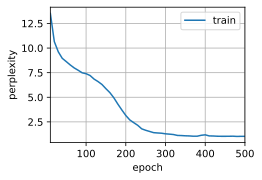

In [14]:
#现在，我们训练循环神经网络模型。因为我们在数据集中只使用10000个词元，所以模型需要更多的迭代周期来更好地收敛。
num_epochs, lr = 500, 1
train_ch8(net, train_iter, vocab, lr, num_epochs, d2l.try_gpu())

困惑度 1.4, 124057.0 词元/秒 cuda:0
time traveller but now you begin to seethe object of my investig
traveller held in his hand was a glitteringmetallic framewo


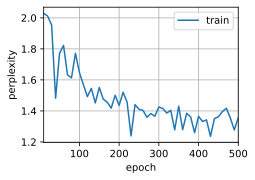

In [15]:
#最后，让我们检查一下使用随机抽样方法的结果。
train_ch8(net, train_iter, vocab, lr, num_epochs, d2l.try_gpu(), use_random_iter=True)